# Some functional components

## Turn a markdown file(including text and image) into vector, use base64 to encode image

In [17]:
import os

md_path = "/home/Preda/user/Sony_InternProj/content/terminology/confusion_matrix/_index.jp.md"
os.path.dirname(os.path.dirname(md_path))

'/home/Preda/user/Sony_InternProj/content/terminology'

---
title: "混同行列"
date: 2018-12-29T11:02:05+06:00
lastmod: 2020-01-05T10:42:26+06:00
weight: 2500
draft: false
# metaタグのパラメータ
meta:
  description: "混同行列は、二値分類・多値分類におけるモデルの性能を確認する方法のひとつです。分類の正解・不正解のしかたの全体像を把握できます。"
# クラウド・デスクトップ限定ページの場合は片方のみtrueにする
visible:
  is_cloud_only: false
  is_desktop_only: false
# 検索でヒットする文字列の指定
keywords: ["混同行列", "混合行列", "閾値"]
---

**混同行列**は、二値分類・多値分類におけるモデルの性能を確認する方法のひとつです。
分類の正解・不正解のしかたの全体像を把握できます。

### 二値分類における混同行列

「退会予測による退会の削減」のチュートリアルを例に説明します。このチュートリアルでは予測したい項目として退会有無を選択しており、ユーザーが「(a)退会」するか「(b)継続中」となるかを当てようとしています。



混同行列を使うと、評価用データに対して予測モデルが退会有無を予測をして、その予測がどの様な場合によく当たるか・外れてしまうかを確認できます。

1 列目に注目すると、評価用データに含まれる「(a)退会」が正解のデータについて、
4 個のデータを「(a)退会」、7 個のデータを「(b)継続中」と予測しました。

**閾値**は、どれくらいの確率で「(a)退会」すると判断したら「(a)退会」と予測するかの基準を表しています。この場合、「(a)退会」する確率が 16%を超えた場合「(a)退会」すると予測しています。その結果得られた混同行列が上の図になります。

### 多値分類における混同行列

予測したい項目の種類が 2 種類より多くなっても見方は同じです。

「顧客の声のラベリング自動化」のチュートリアルを例に説明します。今、
「(a)特になし」、「(b)製品にキズ」「(c)バッテリー」「(d)説明書」「(e)期待はずれ」「(f)複数の苦情」の 6 種類の分類をしたとします。

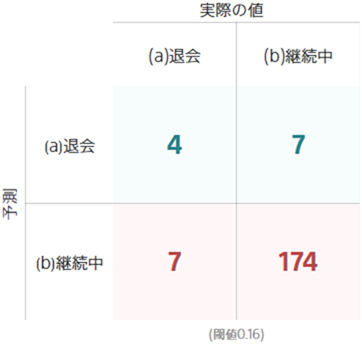
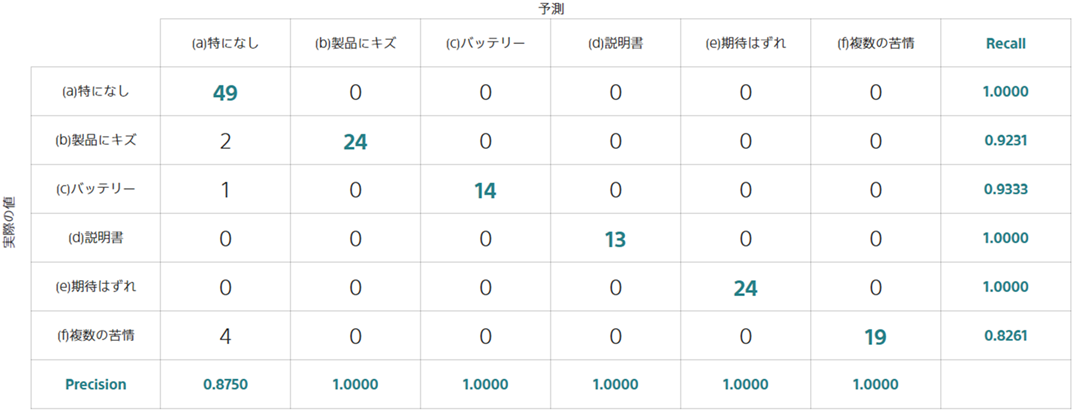

In [18]:
import re
import base64
import os

def encode_image(image_path):
    """将图像文件路径转换为Base64编码"""
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")

def process_markdown(md_path, markdown_text):
    # 提取出 /home/Preda/user/Sony_InternProj/content/terminology/ 目录
    base_dir = os.path.dirname(os.path.dirname(md_path))

    # 处理图片路径，转换成Base64
    def replace_image_path(match):
        # 匹配到的相对路径 ../img/t_slide29.png
        image_relative_path = match.group(1)
        
        # 只提取出 /img/t_slide29.png
        image_relative_path_cleaned = os.path.normpath(image_relative_path.replace("..", ""))
        
        # 拼接基础目录和相对路径，得到绝对路径
        image_path = os.path.join(base_dir, image_relative_path_cleaned.lstrip('/'))
        
        # 检查图片是否存在并进行编码
        if os.path.exists(image_path):
            base64_image = encode_image(image_path)
            return f"![Image](data:image/png;base64,{base64_image})"
        else:
            raise FileNotFoundError(f"图片文件未找到: {image_path}")

    # 匹配 ![](../img/t_slide29.png) 形式的图像路径并替换
    markdown_text = re.sub(r'!\[\]\((\.\./img/[^)]+)\)', replace_image_path, markdown_text)

    # 处理 {{% a_in "../../tutorial/crm_predict_unsubscribe/" "「退会予測による退会の削減」" %}}
    # 只保留引号内的内容
    markdown_text = re.sub(r'\{\{%\s*a_in\s+"[^"]+"\s*"([^"]+)"\s*%\}\}', r'\1', markdown_text)

    # 删除以 {{% div_relitem contents-bottom %}} 开始，以 {{% /div_relitem %}} 结束的内容
    markdown_text = re.sub(r'\{\{%\s*div_relitem\s*contents-bottom\s*%\}\}.*?\{\{%\s*/div_relitem\s*%\}\}', '', markdown_text, flags=re.DOTALL)

    return markdown_text

if __name__ == "__main__":
    # 读取Markdown文件
    with open(md_path, "r", encoding="utf-8") as f:
        markdown_content = f.read()

    # 处理Markdown内容
    processed_content = process_markdown(md_path, markdown_content)

    print(processed_content)

    # # 保存处理后的Markdown内容
    # with open("output.md", "w", encoding="utf-8") as f:
    #     f.write(processed_content)

    # print("Markdown文件处理完毕，结果已保存到output.md")
    


## MarkdownSplitter extract Markdown file and split into chunks

In [37]:
from langchain.text_splitter import RecursiveCharacterTextSplitter, MarkdownHeaderTextSplitter

# 把---包围的内容当作一个整体(元数据)和其他正文内容作为一个整体

# md_path = "/home/Preda/user/Sony_InternProj/content/terminology/accuracy/_index.jp.md"
with open(md_path, "r", encoding="utf-8-sig") as f:
    markdown_content = f.read()
parts = markdown_content.split("---",2)
metadata = parts[1].strip("\n")
content = parts[2].strip("\n")

In [56]:
import yaml

def extract_metadata(metadata_str):
    metadata = yaml.safe_load(metadata_str)
    return {
        "title":metadata.get("title", "").strip(""),
        "description": metadata.get("meta", {}).get("description", "").strip(""),
        "keywords": ",".join([k.strip("") for k in metadata.get("keywords", [])])
    }

print(type(extract_metadata(metadata)))
extract_meta_dict = extract_metadata(metadata)

<class 'dict'>


In [47]:
# 进一步处理正文内容
headers_to_split_on = [
    ("#", "H1"),
    ("##", "H2"),
    ("###", "H3"),
    ("####", "H4"),
    ("#####", "H5"),
    ("######", "H6"),
]
markdown_splitter = MarkdownHeaderTextSplitter(
    headers_to_split_on=headers_to_split_on
)
# metadata就是标题名，page_content就是正文
splits = markdown_splitter.split_text(content)
splits

[Document(page_content='**混同行列**は、二値分類・多値分類におけるモデルの性能を確認する方法のひとつです。\n分類の正解・不正解のしかたの全体像を把握できます。'),
 Document(metadata={'H3': '二値分類における混同行列'}, page_content='{{% a_in "../../tutorial/crm_predict_unsubscribe/" "「退会予測による退会の削減」" %}}のチュートリアルを例に説明します。このチュートリアルでは予測したい項目として退会有無を選択しており、ユーザーが「(a)退会」するか「(b)継続中」となるかを当てようとしています。  \n![](../img/t_slide29.png)  \n混同行列を使うと、評価用データに対して予測モデルが退会有無を予測をして、その予測がどの様な場合によく当たるか・外れてしまうかを確認できます。  \n1 列目に注目すると、評価用データに含まれる「(a)退会」が正解のデータについて、\n4 個のデータを「(a)退会」、7 個のデータを「(b)継続中」と予測しました。  \n**閾値**は、どれくらいの確率で「(a)退会」すると判断したら「(a)退会」と予測するかの基準を表しています。この場合、「(a)退会」する確率が 16%を超えた場合「(a)退会」すると予測しています。その結果得られた混同行列が上の図になります。'),
 Document(metadata={'H3': '多値分類における混同行列'}, page_content='予測したい項目の種類が 2 種類より多くなっても見方は同じです。  \n{{% a_in "../../tutorial/crm_automate_voice_of_the_customer_labeling/" "「顧客の声のラベリング自動化」" %}}のチュートリアルを例に説明します。今、\n「(a)特になし」、「(b)製品にキズ」「(c)バッテリー」「(d)説明書」「(e)期待はずれ」「(f)複数の苦情」の 6 種類の分類をしたとします。  \n![](../img/t_slide30.png)  \nこの場合、評価用データに含まれる「(b)製品にキズ」が正解のデータについて、\n2 個のデータを「(

In [51]:
"H3" in splits[1].metadata

True

In [58]:
# 合并元数据和分割后的内容
combined_chunks = []
for split in splits:
    combined_text = f"Title: {extract_meta_dict["title"]}\n"
    combined_text += f"Description: {extract_meta_dict["description"]}\n"
    combined_text += f"Keywords: {extract_meta_dict["keywords"]}\n"
    # 检查是否有标题
    if split.metadata:
        for header_level in ["H1", "H2", "H3", "H4", "H5", "H6"]:
            if header_level in split.metadata:
                combined_text += f"Subtitle: {split.metadata.values}"
                break
    combined_text += f"Content: {split.page_content}"
    combined_chunks.append(combined_text)

combined_chunks

['Title: 混同行列\nDescription: 混同行列は、二値分類・多値分類におけるモデルの性能を確認する方法のひとつです。分類の正解・不正解のしかたの全体像を把握できます。\nKeywords: 混同行列,混合行列,閾値\nContent: **混同行列**は、二値分類・多値分類におけるモデルの性能を確認する方法のひとつです。\n分類の正解・不正解のしかたの全体像を把握できます。',
 'Title: 混同行列\nDescription: 混同行列は、二値分類・多値分類におけるモデルの性能を確認する方法のひとつです。分類の正解・不正解のしかたの全体像を把握できます。\nKeywords: 混同行列,混合行列,閾値\nSubtitle: <built-in method values of dict object at 0x7fbe5a17c8c0>Content: {{% a_in "../../tutorial/crm_predict_unsubscribe/" "「退会予測による退会の削減」" %}}のチュートリアルを例に説明します。このチュートリアルでは予測したい項目として退会有無を選択しており、ユーザーが「(a)退会」するか「(b)継続中」となるかを当てようとしています。  \n![](../img/t_slide29.png)  \n混同行列を使うと、評価用データに対して予測モデルが退会有無を予測をして、その予測がどの様な場合によく当たるか・外れてしまうかを確認できます。  \n1 列目に注目すると、評価用データに含まれる「(a)退会」が正解のデータについて、\n4 個のデータを「(a)退会」、7 個のデータを「(b)継続中」と予測しました。  \n**閾値**は、どれくらいの確率で「(a)退会」すると判断したら「(a)退会」と予測するかの基準を表しています。この場合、「(a)退会」する確率が 16%を超えた場合「(a)退会」すると予測しています。その結果得られた混同行列が上の図になります。',
 'Title: 混同行列\nDescription: 混同行列は、二値分類・多値分類におけるモデルの性能を確認する方法のひとつです。分類の正解・不正解のしかたの全体像を把握できます。\nKeywords: 混同行列,混合行列,閾値\nSubtitle

In [62]:
type(combined_chunks)

list

## Create RAG vectorstore

### OpenAI Embedding

In [60]:
from typing import Optional, Any
from dotenv import load_dotenv
import os
from langchain_openai import AzureOpenAIEmbeddings

load_dotenv()

def create_embeddings_model(
    model_name: Optional[str] = "text-embedding-3-large",
    chunk_size: int = 2048,
    api_key: Optional[str] = None,
    api_version: Optional[str] = "2024-02-01",
    azure_endpoint: Optional[str] = 'https://azure-preone-openai-sweden-central-01-chen.openai.azure.com/',
    **kwargs: dict[str, Any],
) -> AzureOpenAIEmbeddings:
    # NOTE:初期値はAzureOpenAIEmbeddingsを準拠
    if not model_name:
        model_name = os.environ.get("OPENAI_MODEL_EMBEDDINGS", "text-embedding-ada-002")
    if not azure_endpoint:
        azure_endpoint = os.environ.get("AZURE_OPENAI_ENDPOINT_EMBEDDINGS") or os.environ["AZURE_OPENAI_ENDPOINT"]
    if not api_key:
        api_key = os.environ['OPENAI_API_KEY']
    if not api_version:
        api_version = os.environ["OPENAI_API_VERSION"]

    return AzureOpenAIEmbeddings(
        model=model_name,
        chunk_size=chunk_size,
        api_key=api_key,
        api_version=api_version,
        azure_endpoint=azure_endpoint,
        **kwargs,
    )

In [61]:
from langchain_community.vectorstores.faiss import FAISS
from typing import List
from datetime import datetime

def create_vectorstore(
        custom_chunks: List[str],
        store_db_nm: str,
        model: str,
        input_file: str,
        env_name: str,
):
    # 自定义格式的文本转换为 Document 对象
    documents = [
        {
            "page_content": chunk,
            "metadata": {
                "source": input_file,
                "chunk_id": i,
            }
        } for i, chunk in enumerate(custom_chunks)
    ]
    embeddings = create_embeddings_model(chunk_size=2048)
    vectordb = FAISS.from_texts([doc["page_content"] for doc in documents], embeddings, metadatas=[doc["metadata"] for doc in documents])
    export_db_path = f"../../data/{env_name}/stores/{store_db_nm}"
    vectordb.save_local(f"{export_db_path}/vector_store")
    config_path = os.path.join(export_db_path, "config.txt")
    with open(config_path, "w") as f:
        current_time = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        config_content = (
            f"embedding_model: {model}\n"
            f"input_file: {input_file}\n"
            f"time: {current_time}"
        )
        f.write(config_content)
    return vectordb
